In [599]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

In [600]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

def get_points_and_colors_from_las(las_path: str, limit: int = -1):
    if not isinstance(las_path, str):
        raise ValueError("las_path must be a string.")
    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    las = read_las_file(las_path)
    if las is None:
        raise ValueError("No valid LAS file found.")

    points = np.vstack((las.x, las.y, las.z)).transpose()
    colors = np.vstack((las.red, las.green, las.blue)).transpose()

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]

    rgba_colors = normalize_colors(colors)
    return points, colors, rgba_colors, np.expand_dims(las.classification, -1), np.expand_dims(las.intensity, -1) 

In [601]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points, radius=0.1, min_neighbors=3):
    tree = KDTree(points)
    distances, _ = tree.query(points, k=min_neighbors, distance_upper_bound=radius)
    mask = np.all(distances < radius, axis=1)
    return mask #(N,3)

def remove_low_intensity_points(points):
    intensity_mean, intensity_std = np.mean(points), np.std(points)
    lower_threshold = intensity_mean - 2 * intensity_std
    upper_threshold = intensity_mean + 2 * intensity_std
    mask = (points > lower_threshold) & (points < upper_threshold)
    return mask

In [602]:
METHOD = 'mean'
POOL_NAME = 'K54.4'
FRECUENCY = '100kHz'    
PROJECT_NAME = f'250116_South_100kHz_220m'
PATH_PROJECT_LAS = f'data/{FRECUENCY}/{PROJECT_NAME}/{POOL_NAME}_clasificada_col_0_row_0_19s.las'
OUTPUTS_PATH = f'discrete_model/{METHOD}/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

In [603]:
# bottom_pools = {'RBS': 2300.26, 'RBN': 2300.46, '1B': 2300.54, 
#                '2B': 2300.48, '4A': 2300.24, 'H13': 2300.05, 
#                'H14': 2300.24, 'H15': '2300.01', 'H16': 2299.85, 
#                'H17': 2299.24, 'K51': '2300.49', 'K52': 2300.46, 
#                'K53': 2300.41, 'K54': '2300.38', 'HK13': 2300.77, 
#                'HK14': 2300.54, 'K36': '2300.89', 'K37': 2300.51, 
#                '9F': 2300.30, '9E': 2300.27, '11G': 2300.33, 
#                '11F': 2300.27, '11JC': 2300.30, '10J': 2300.35, 
#                '10I': 2300.18, '10H': 2300.34}

# bottom_pool = bottom_pools.get(POOL_NAME, '')


In [604]:
las_points, las_colors, las_rgba_colors, las_clasification, las_intensity = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_data_points = np.hstack((las_points, las_rgba_colors, las_intensity, las_clasification)) #(N,8)

# mask = las_data_points[:,2] > bottom_pool
# las_data_points = las_data_points[mask]

other_points = las_data_points[las_data_points[:,-1] != 65]
water_points = las_data_points[las_data_points[:,-1] == 65]

mask = remove_low_density_points(other_points[:,:3], min_neighbors=5)
other_points = other_points[mask]

mask = remove_low_intensity_points(other_points[:,-2])
other_points = other_points[mask]

las_points = np.concatenate((other_points, water_points), axis=0) #(N,7)
las_points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(las_points[:,:3])

other_points = las_points_norm[las_points[:,-1] != 65]
water_points = las_points_norm[las_points[:,-1] == 65]

mean_of_water_points = np.mean(water_points[:,2], axis=0)

DELTA_WATER = mean_of_water_points * 0.1 #0.25 

X = other_points[:, 0]
Y = other_points[:, 1]
Z = other_points[:, 2]

distances = Z - mean_of_water_points

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -DELTA_WATER
above_plane = distances >= DELTA_WATER

points_below = np.column_stack((X[below_plane], Y[below_plane], Z[below_plane]))
points_above = np.column_stack((X[above_plane], Y[above_plane], Z[above_plane]))

In [605]:
# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# # Añadir los puntos por encima del plano en rojo
points_above_pv = pv.PolyData(points_above)
plotter.add_points(points_above_pv, color='red', point_size=5)

# # Añadir los puntos de agua en amarillo
water_points_pv = pv.PolyData(water_points[:,:3])
plotter.add_points(water_points_pv, color='yellow', point_size=5)

# # Añadir la superficie del plano al plotter
plane = pv.Plane(center=[0.5, 0.5, mean_of_water_points], direction=[0, 0, 1], i_size=1, j_size=1)
#plotter.add_mesh(plane, color='blue')

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:40235/index.html?ui=P_0x7f2f93f590c0_68&reconnect=auto" class="pyv…

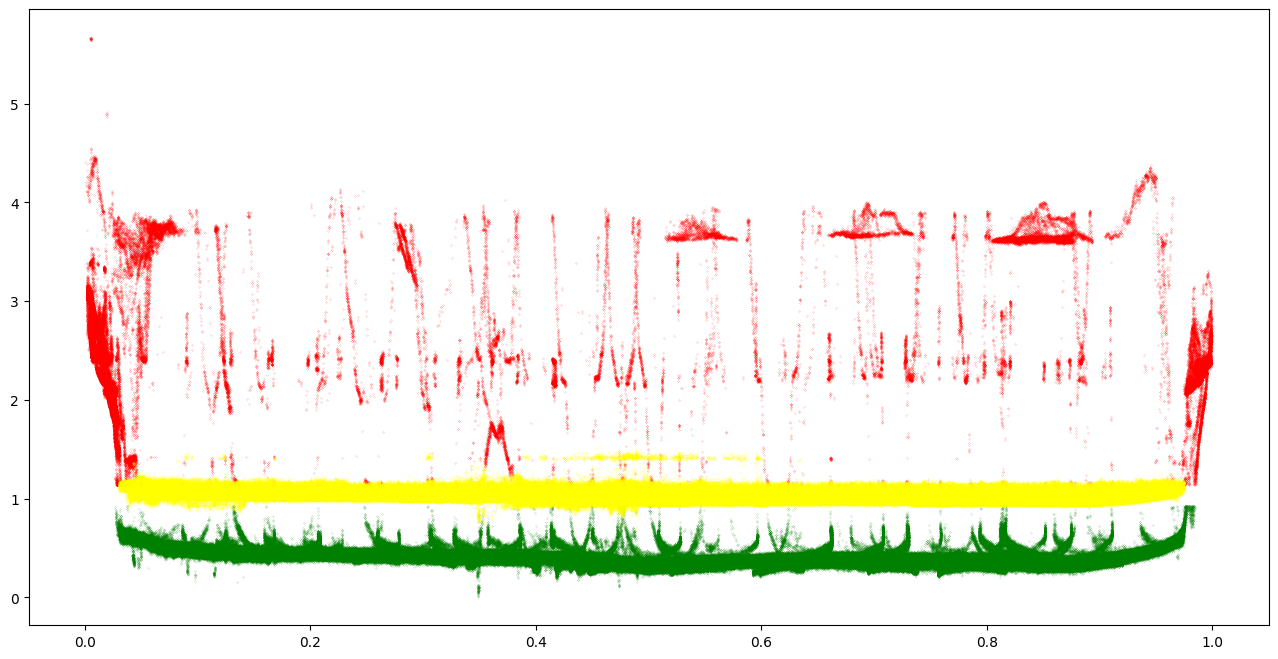

In [606]:
plt.figure(figsize=(16,8))
plt.scatter( points_below[:,1], points_below[:,2]*(z_max-z_min), c='green', s=0.01)
plt.scatter( points_above[:,1], points_above[:,2]*(z_max-z_min), c='red', s=0.01)
plt.scatter( water_points[:,1], water_points[:,2] *(z_max-z_min), c='yellow', s=0.01)
plt.show()  

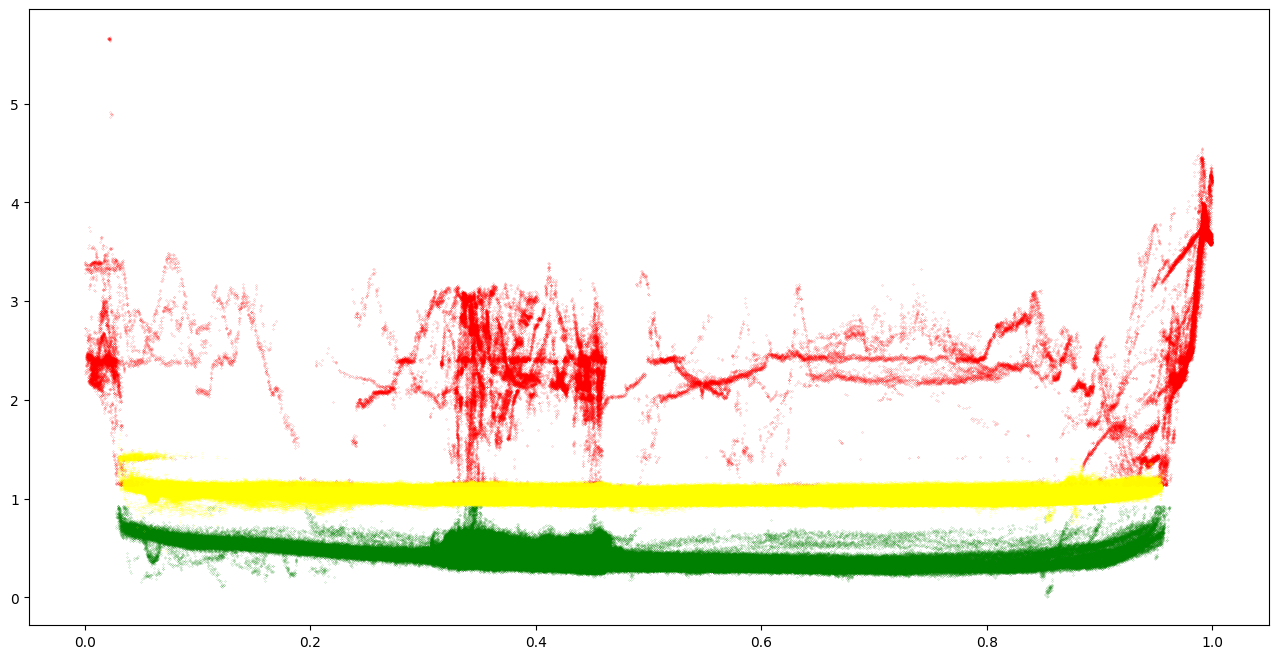

In [607]:
plt.figure(figsize=(16,8))
plt.scatter( points_below[:,0], points_below[:,2]*(z_max-z_min), c='green', s=0.01)
plt.scatter( points_above[:,0], points_above[:,2]*(z_max-z_min), c='red', s=0.01)
plt.scatter( water_points[:,0], water_points[:,2]*(z_max-z_min), c='yellow', s=0.01)
plt.show()  

In [608]:
# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.01

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

mask_on_diagonal1 = remove_low_density_points(points_on_diagonal1, radius=threshold, min_neighbors=10)
mask_on_diagonal2 = remove_low_density_points(points_on_diagonal2, radius=threshold, min_neighbors=10)

points_on_diagonal1 = points_on_diagonal1[mask_on_diagonal1]
points_on_diagonal2 = points_on_diagonal2[mask_on_diagonal2]


# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:40235/index.html?ui=P_0x7f2f67eed870_69&reconnect=auto" class="pyv…

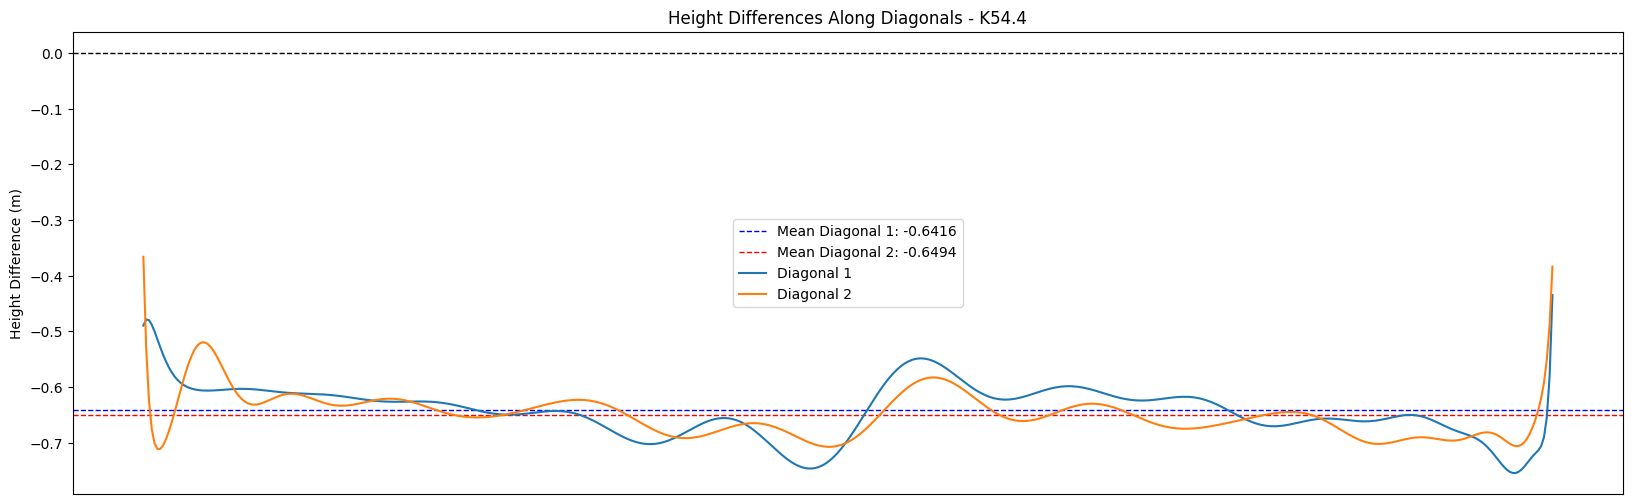

In [609]:
method_dic = {'mean': np.mean(water_points[:,2], axis=0),
 'p99': np.percentile(water_points[:,2], 99),}

height_water = method_dic.get(METHOD, 'mean')

z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

degree = 30  
poly_d1 = Polynomial.fit(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, degree)
poly_d2 = Polynomial.fit(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, degree)

x_new_d1 = np.linspace(0, 1, 500)
x_new_d2 = np.linspace(0, 1, 500)
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal 1')
plt.plot(x_new_d2, z_new_d2, label='Diagonal 2')
plt.ylabel('Height Difference (m)')
plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
plt.xticks([])
plt.legend()
plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
plt.show()

In [610]:
# plt.figure(figsize=(20, 6))
# plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.4f}')
# plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.4f}')
# plt.plot(np.arange(len(z_d1))/(len(z_d1)-1), z_d1, label='Diagonal 1')
# plt.plot(np.arange(len(z_d2))/(len(z_d2)-1), z_d2, label='Diagonal 2')
# plt.ylabel('Height Difference (m)')
# plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
# plt.xticks([])
# plt.legend()
# plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
# plt.show()

In [611]:
z_points = (height_water - points_below[:,2]) * (z_max - z_min) * -1 
depth_mean_pool = np.mean(z_points)

In [612]:
height_water * (z_max - z_min) + z_min, height_water * (z_max - z_min) + z_min + depth_mean_pool

(np.float64(2347.8904018013), np.float64(2347.2672307133716))

In [613]:
import json

file = {
    "height_water_normalized": height_water,
    "depth_pool": {
        "mean" :depth_mean_pool,
        "unit": "[m]"
    },
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "unit": "[m]",
        "mean": mean_diagonal1,
        "x_axis": x_new_d1.tolist(),
        "y_axis": z_new_d1.tolist(),
    },
    "diagonal2" : {
        "unit": "[m]",
        "mean": mean_diagonal2,
        "x_axis": x_new_d2.tolist(),
        "y_axis": z_new_d2.tolist(),
    }
}

with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
    json.dump(file, json_file, indent=4)

Grid Resolution: 1024 x 1573


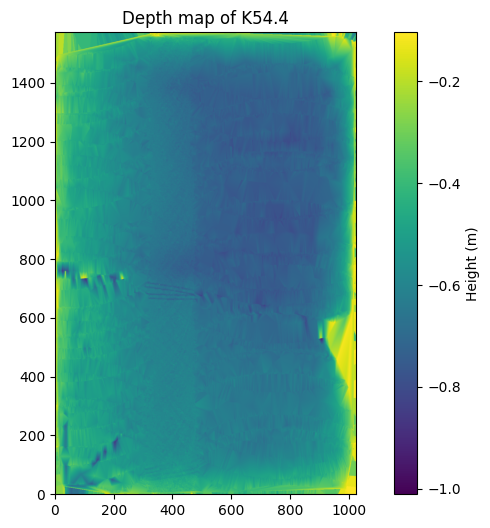

In [614]:
z_below = points_below[:, 2]
z = (height_water - z_below) * (z_max - z_min)

water_points = water_points * np.array([x_max - x_min, y_max - y_min, z_max - z_min])  
points_below = points_below * np.array([x_max - x_min, y_max - y_min, z_max - z_min])

x0, y0, z0 = water_points[:, 0], water_points[:, 1], water_points[:, 2]
x1, y1, z1 = points_below[:, 0], points_below[:, 1], points_below[:, 2]

grid_res_x = 1024  
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()
grid_res_y = int(grid_res_x * (y1_max - y1_min) / (x1_max - x1_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

# First interpolation using linear method
grid_z_linear = griddata((x1, y1), z, (grid_x, grid_y), method="linear") * -1

# Second interpolation using nearest method to ensure complete surface
grid_z_nearest = griddata((x1, y1), z, (grid_x, grid_y), method="nearest") * -1

# Combine the results to ensure complete surface
grid_z = np.where(np.isnan(grid_z_linear), grid_z_nearest, grid_z_linear)

# Plotting the combined result
plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title(f'Depth map of {POOL_NAME}')
plt.show()

In [615]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')